In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install "torch==1.4" "torchvision==0.5.0"

In [ ]:
from fastai.vision import *

### Data

In [ ]:
path = Path("/content/drive/My Drive/COVID19_02_10_20/PROCESSED_DATASET/DATASET")

In [ ]:
print(path)

/content/drive/My Drive/COVID19_02_10_20/PROCESSED_DATASET/DATASET


In [ ]:
path.ls()

[PosixPath('/content/drive/My Drive/COVID19_02_10_20/PROCESSED_DATASET/DATASET/COVID19'),
 PosixPath('/content/drive/My Drive/COVID19_02_10_20/PROCESSED_DATASET/DATASET/NORMAL'),
 PosixPath('/content/drive/My Drive/COVID19_02_10_20/PROCESSED_DATASET/DATASET/PNEUMONIA'),
 PosixPath('/content/drive/My Drive/COVID19_02_10_20/PROCESSED_DATASET/DATASET/models')]

In [ ]:
np.random.seed(41)
data = ImageDataBunch.from_folder(path, train="Train", valid ="Valid", valid_pct=0.2,
        ds_tfms=get_transforms(), size=(256,256), bs=32, num_workers=4).normalize()

In [ ]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['COVID19', 'NORMAL', 'PNEUMONIA'], 3, 2995, 748)

In [ ]:
print("Number of examples in training:", len(data.train_ds))
print("Number of examples in validation:", len(data.valid_ds))

Number of examples in training: 2995
Number of examples in validation: 748


In [ ]:
xb,yb = data.one_batch()
xb.shape,yb.shape

(torch.Size([32, 3, 256, 256]), torch.Size([32]))

---

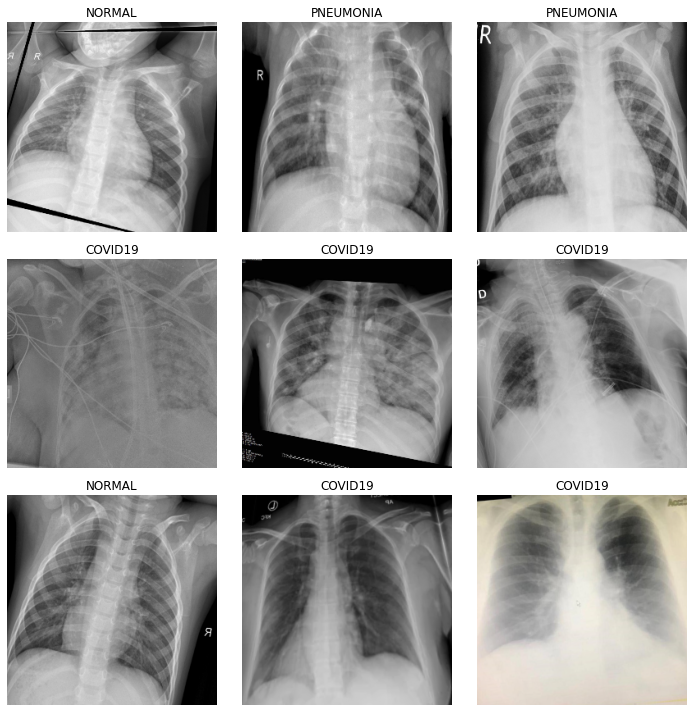

In [ ]:
data.show_batch(rows=3, figsize=(10,10))

# MODEL

## CUSTOM_7 MODEL

In [ ]:
def conv_block(ni, nf, size=3, stride=1):
    for_pad = lambda s: s if s > 2 else 3
    return nn.Sequential(
        nn.Conv2d(ni, nf, kernel_size=size, stride=stride,
                  padding=(for_pad(size) - 1)//2, bias=False), 
        nn.BatchNorm2d(nf),
        nn.ReLU()
    )

In [ ]:
def conv_block_and_res(ni, nf): return nn.Sequential(
    conv_block(ni, nf),
    conv_block(nf, ni, size=1),  
    conv_block(ni, nf), 
    res_block(nf))

In [ ]:
def maxpooling():
    return nn.MaxPool2d(2, stride=2)

In [ ]:
model = nn.Sequential(
    conv_block(3, 8),

    conv_block(8, 16),
    maxpooling(),

    conv_block_and_res(16,32),
    maxpooling(),

    conv_block_and_res(32,64),
    maxpooling(),

    conv_block_and_res(64,128),
    maxpooling(),

    conv_block_and_res(128,256),
    conv_block(256, 512),
    conv_block(512, 1024),

    conv_block(1024, 512, size=1),
    conv_block(512, 1024),
    conv_layer(1024, 3),
    nn.AvgPool2d(2),
    Flatten(),
    nn.Linear(300, 3)
)

# Check Model

In [ ]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [ ]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 256, 256]        216        True      
______________________________________________________________________
BatchNorm2d          [8, 256, 256]        16         True      
______________________________________________________________________
ReLU                 [8, 256, 256]        0          False     
______________________________________________________________________
Conv2d               [16, 256, 256]       1,152      True      
______________________________________________________________________
BatchNorm2d          [16, 256, 256]       32         True      
______________________________________________________________________
ReLU                 [16, 256, 256]       0          False     
______________________________________________________________________
MaxPool2d            [16, 128, 128]       0          False     
___________________________________________________

## Model ResNet

In [ ]:
class ResBlock(nn.Module):
  def __init__(self, nf):
    super().__init__()
    self.conv1 = conv_layer(nf,nf)
    self.conv2 = conv_layer(nf,nf)
    
  def forward(self,x): return x + self.conv2(self.conv1(x))

In [ ]:
model = nn.Sequential(
    conv2d(3, 8),
    res_block(8),
    conv2d(8,16),
    res_block(16),
    conv2d(16,30),
    res_block(32),
    conv2d(32,16),
    res_block(16),
    Flatten()
)

In [ ]:
def conv_and_res(ni, nf): return nn.Sequential(conv2d(ni, nf), res_block(nf))

In [ ]:
model = nn.Sequential(
    conv_and_res(3,8),
    conv_and_res(8,16),
    conv_and_res(16,32),
    conv_and_res(32,16),
    conv2d(16,10),
    Flatten()
)

In [ ]:
# def resblock_body(x, num_filters, num_blocks):
#     '''A series of resblocks starting with a downsampling Convolution2D'''
#     # Darknet uses left and top padding instead of 'same' mode
#     x = ZeroPadding2D(((1,0),(1,0)))(x)
#     x = DarknetConv2D_BN_Leaky(num_filters, (3,3), strides=(2,2))(x)
#     for i in range(num_blocks):
#         y = compose(
#                 DarknetConv2D_BN_Leaky(num_filters//2, (1,1)),
#                 DarknetConv2D_BN_Leaky(num_filters, (3,3)))(x)
#         x = Add()([x,y])
#     return x


In [ ]:
# def res_block(x, nf, nb):
#   for i in range(nb):
#     y = compose(
#         conv_block(x, nf//2, size=1),
#         conv_block(x, nf, size=3)
#     )
#     x = torch.add([x,y])
#   return x


# `Train Model

In [ ]:
# learn.lr_find(end_lr=100)
# learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(100, max_lr=3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.424121,0.270240,0.911765,02:24
1,0.295493,0.220395,0.935829,02:19
2,0.249897,0.311573,0.905080,02:21
3,0.243746,0.259909,0.907754,02:20
4,0.276819,0.249811,0.915775,02:21
5,0.240580,0.484903,0.802139,02:21
6,0.255330,0.216210,0.919786,02:20
7,0.244049,0.510222,0.844920,02:21
8,0.233975,0.515910,0.786096,02:24
9,0.268720,0.316055,0.881016,02:26


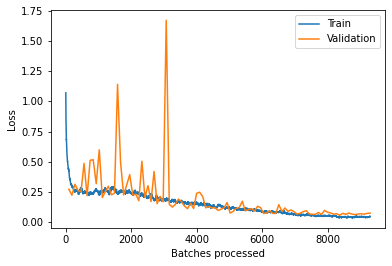

In [ ]:
learn.recorder.plot_losses()

In [ ]:
print("Number of examples in testing:", len(data.valid_ds))

Number of examples in testing: 748


In [ ]:
probs,targets = learn.get_preds(ds_type=DatasetType.Valid) # Predicting without TTA

In [ ]:
accuracy(probs,targets)

In [ ]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['COVID19', 'NORMAL', 'PNEUMONIA'], 3, 2995, 748)

In [ ]:
probs = np.argmax(probs, axis=1)
correct = 0
for idx, pred in enumerate(probs):
    if pred == targets[idx]:
        correct += 1
accuracy = correct / len(probs)
print(len(probs), correct, accuracy)

from sklearn.metrics import confusion_matrix
np.set_printoptions(threshold=np.inf) # shows whole confusion matrix
cm1 = confusion_matrix(targets, probs)
print(cm1)

from sklearn.metrics import classification_report
y_true1 = targets
y_pred1 = probs
target_names = ['Covid-19', 'No_findings', 'Pneumonia']
print(classification_report(y_true1, y_pred1, target_names=target_names))

748 731 0.9772727272727273
[[229   0   0]
 [  1 255   1]
 [  0  15 247]]
              precision    recall  f1-score   support

    Covid-19       1.00      1.00      1.00       229
 No_findings       0.94      0.99      0.97       257
   Pneumonia       1.00      0.94      0.97       262

    accuracy                           0.98       748
   macro avg       0.98      0.98      0.98       748
weighted avg       0.98      0.98      0.98       748



In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

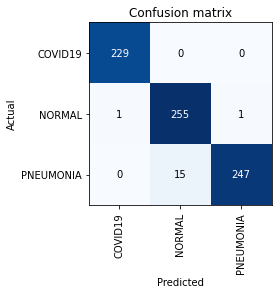

In [ ]:
cm_fig = interp.plot_confusion_matrix(return_fig=True)
ax = cm_fig.gca()
ax.set_ylim(interp.data.c - .5, - .5);